1. Advanced Reservoir Characterization with Machine Learning

C:\Users\G15\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating advanced synthetic well log data...
Calculating advanced petrophysical properties...
Training machine learning models for lithology prediction...
Random Forest Classification Report:
              precision    recall  f1-score   support

    DOLOMITE       1.00      0.98      0.99       132
   LIMESTONE       0.99      0.96      0.98       173
   SANDSTONE       0.99      1.00      0.99       814
       SHALE       1.00      1.00      1.00      3381

    accuracy                           1.00      4500
   macro avg       1.00      0.98      0.99      4500
weighted avg       1.00      1.00      1.00      4500

XGBoost Classification Report:
              precision    recall  f1-score   support

    DOLOMITE       0.96      0.99      0.97       132
   LIMESTONE       0.97      1.00      0.99       173
   SANDSTONE       0.99      0.99      0.99       814
       SHALE       1.00      1.00      1.00      3381

    accuracy                           0.99      4500
   macro avg  

<Figure size 1000x800 with 0 Axes>

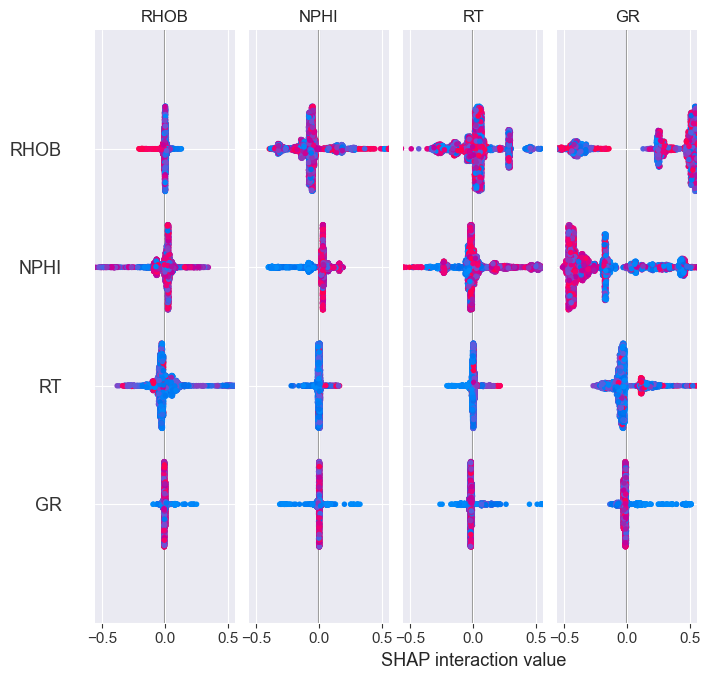

Training machine learning models for permeability prediction...
Random Forest R²: -258063.0000
XGBoost R²: -11529214960169120.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reservoir Statistics by Well:
     WELL  NET_PAY       HCPV  PERM_TIMUR      PHIA  SW_SIMANDOUX
0  Well_0      846  88.020043         0.1  0.156360      0.606989
1  Well_1      674  58.432129         0.1  0.220268      0.345404
2  Well_2      149  14.263973         0.1  0.197286      0.402287
3  Well_3      554  44.636382         0.1  0.189606      0.335357
4  Well_4      557  67.015570         0.1  0.220735      0.294333
Advanced well analysis completed and results saved.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, r2_score
import xgboost as xgb
import shap  # SHapley Additive exPlanations for model interpretation
from scipy import interpolate
import lasio
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Generate sophisticated synthetic well log data with realistic patterns
def create_advanced_synthetic_logs(n_wells=5, depth_range=(1500, 3000), resolution=0.5):
    """
    Create realistic synthetic well log data for multiple wells
    with correlated petrophysical properties
    """
    all_wells = []
    
    for well_id in range(n_wells):
        # Create depth array
        depth = np.arange(depth_range[0], depth_range[1], resolution)
        
        # Create realistic geological layers with different properties
        layer_depths = np.linspace(depth_range[0], depth_range[1], 10)
        layer_properties = []
        
        for i in range(len(layer_depths)-1):
            # Randomly assign layer properties
            gr_mean = np.random.uniform(40, 120)
            rt_mean = np.random.uniform(5, 100)
            nphi_mean = np.random.uniform(0.05, 0.35)
            rhob_mean = np.random.uniform(2.0, 2.8)
            pe_mean = np.random.uniform(1.5, 5.0)
            
            layer_properties.append({
                'top': layer_depths[i],
                'bottom': layer_depths[i+1],
                'gr_mean': gr_mean,
                'rt_mean': rt_mean,
                'nphi_mean': nphi_mean,
                'rhob_mean': rhob_mean,
                'pe_mean': pe_mean
            })
        
        # Initialize logs
        gr = np.zeros_like(depth)
        rt = np.zeros_like(depth)
        nphi = np.zeros_like(depth)
        rhob = np.zeros_like(depth)
        pe = np.zeros_like(depth)
        
        # Fill logs based on layer properties
        for i, d in enumerate(depth):
            for layer in layer_properties:
                if layer['top'] <= d <= layer['bottom']:
                    # Add noise and trends to make it realistic
                    gr[i] = layer['gr_mean'] + np.random.normal(0, 10)
                    rt[i] = layer['rt_mean'] * np.exp(-0.0001 * (d - depth_range[0])) + np.random.normal(0, 5)
                    nphi[i] = layer['nphi_mean'] + np.random.normal(0, 0.03)
                    rhob[i] = layer['rhob_mean'] + np.random.normal(0, 0.08)
                    pe[i] = layer['pe_mean'] + np.random.normal(0, 0.3)
                    break
        
        # Create fluid contacts
        owc = np.random.uniform(2000, 2800)  # Oil-water contact
        goc = owc - np.random.uniform(50, 150)  # Gas-oil contact
        
        # Create lithology based on log responses
        lithology = np.full_like(depth, 'SHALE', dtype=object)
        
        # Sandstone criteria
        sand_mask = (gr < 75) & (rt > 15) & (nphi > 0.12)
        lithology[sand_mask] = 'SANDSTONE'
        
        # Limestone criteria
        lime_mask = (gr < 60) & (rt > 20) & (pe > 3) & (rhob > 2.5)
        lithology[lime_mask] = 'LIMESTONE'
        
        # Dolomite criteria
        dolomite_mask = (gr < 50) & (rt > 25) & (pe < 3) & (nphi > 0.08)
        lithology[dolomite_mask] = 'DOLOMITE'
        
        # Add hydrocarbon effects
        hydrocarbon_mask = (depth < owc) & (lithology != 'SHALE')
        
        # Increase resistivity in hydrocarbon zones
        rt[hydrocarbon_mask] = rt[hydrocarbon_mask] * np.random.uniform(2, 5)
        
        # Gas effect (increase density porosity, decrease neutron porosity)
        gas_mask = (depth < goc) & hydrocarbon_mask
        nphi[gas_mask] = nphi[gas_mask] * np.random.uniform(0.7, 0.9)
        rhob[gas_mask] = rhob[gas_mask] * np.random.uniform(0.85, 0.95)
        
        # Create DataFrame for this well
        well_df = pd.DataFrame({
            'WELL': f'Well_{well_id}',
            'DEPTH': depth,
            'GR': gr,
            'RT': rt,
            'NPHI': nphi,
            'RHOB': rhob,
            'PE': pe,
            'LITHOLOGY': lithology,
            'OWC': owc,
            'GOC': goc,
            'HYDROCARBON': hydrocarbon_mask.astype(int),
            'GAS': gas_mask.astype(int)
        })
        
        all_wells.append(well_df)
    
    return pd.concat(all_wells, ignore_index=True)

# Generate synthetic data for multiple wells
print("Generating advanced synthetic well log data...")
advanced_wells_df = create_advanced_synthetic_logs(n_wells=5)

# Advanced petrophysical calculations
def advanced_petrophysics(df):
    """Calculate advanced petrophysical properties"""
    
    # VShale from Gamma Ray (linear and non-linear methods)
    gr_min, gr_max = 40, 120
    df['VSHALE_GR'] = (df['GR'] - gr_min) / (gr_max - gr_min)
    df['VSHALE_GR'] = np.clip(df['VSHALE_GR'], 0, 1)
    
    # VShale from Neutron-Density separation
    df['VSHALE_ND'] = (df['NPHI'] - 0.33 * df['RHOB'] + 0.77) / (0.09 - 0.33 * 2.65 + 0.77)
    df['VSHALE_ND'] = np.clip(df['VSHALE_ND'], 0, 1)
    
    # Porosity calculations
    # Density porosity
    rhob_matrix, rhob_fluid = 2.65, 1.0
    df['PHID'] = (rhob_matrix - df['RHOB']) / (rhob_matrix - rhob_fluid)
    df['PHID'] = np.clip(df['PHID'], 0, 0.4)
    
    # Neutron porosity (already in NPHI)
    df['PHIN'] = df['NPHI']
    
    # Average porosity
    df['PHIA'] = (df['PHID'] + df['PHIN']) / 2
    
    # Sonic porosity (Wyllie time average equation)
    # Assuming DT matrix = 55 μs/ft, DT fluid = 189 μs/ft
    # We'd need DT log for this, so we'll skip for now
    
    # Water saturation (Archie, Simandoux, Indonesia equations)
    # Archie
    a, m, n, rw = 1.0, 2.0, 2.0, 0.1
    f = a / (df['PHIA'] ** m)
    df['SW_ARCHIE'] = (f * rw / df['RT']) ** (1/n)
    df['SW_ARCHIE'] = np.clip(df['SW_ARCHIE'], 0.1, 1.0)
    
    # Simandoux (for shaly sands)
    # Simplified version
    b = 1.0  # Constant
    df['SW_SIMANDOUX'] = np.sqrt(
        (f * rw) / (df['RT'] * df['PHIA']**2) + 
        (b * rw * df['VSHALE_GR']) / (2 * df['RT'] * df['PHIA'])
    ) - (b * df['VSHALE_GR']) / (2 * df['PHIA'])
    df['SW_SIMANDOUX'] = np.clip(df['SW_SIMANDOUX'], 0.1, 1.0)
    
    # Permeability estimation (Timur, Coates, etc.)
    # Timur equation: K = 0.136 * PHIA^4.4 / SW_IRR^2
    sw_irr = 0.2  # Irreducible water saturation
    df['PERM_TIMUR'] = 0.136 * (df['PHIA']**4.4) / (sw_irr**2)
    df['PERM_TIMUR'] = np.clip(df['PERM_TIMUR'], 0.1, 5000)  # Limit to reasonable values
    
    # Net pay flags
    df['NET_PAY'] = ((df['VSHALE_GR'] < 0.4) & 
                     (df['PHIA'] > 0.1) & 
                     (df['SW_SIMANDOUX'] < 0.6)).astype(int)
    
    # Hydrocarbon pore volume
    df['HCPV'] = df['PHIA'] * (1 - df['SW_SIMANDOUX']) * df['NET_PAY'] * 0.5  # 0.5m resolution
    
    return df

# Apply advanced petrophysical calculations
print("Calculating advanced petrophysical properties...")
advanced_wells_df = advanced_petrophysics(advanced_wells_df)

# Machine Learning for lithology prediction
print("Training machine learning models for lithology prediction...")

# Prepare data for ML
ml_df = advanced_wells_df.dropna(subset=['GR', 'RT', 'NPHI', 'RHOB', 'PE', 'LITHOLOGY']).copy()

# Encode lithology labels
le = LabelEncoder()
ml_df['LITHOLOGY_CODE'] = le.fit_transform(ml_df['LITHOLOGY'])

# Features and target
features = ['GR', 'RT', 'NPHI', 'RHOB', 'PE']
X = ml_df[features]
y = ml_df['LITHOLOGY_CODE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest classifier
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}
rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train_scaled, y_train)

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_clf.fit(X_train_scaled, y_train)

# Evaluate models
rf_pred = rf_clf.predict(X_test_scaled)
xgb_pred = xgb_clf.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=le.classes_))

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred, target_names=le.classes_))

# Add predictions to dataframe
ml_df['RF_LITHOLOGY'] = le.inverse_transform(rf_clf.predict(scaler.transform(ml_df[features])))
ml_df['XGB_LITHOLOGY'] = le.inverse_transform(xgb_clf.predict(scaler.transform(ml_df[features])))

# SHAP analysis for model interpretation
print("Performing SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, class_names=le.classes_)
plt.title('SHAP Summary Plot for Lithology Classification')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()

# Machine Learning for permeability prediction
print("Training machine learning models for permeability prediction...")

# Prepare data for permeability prediction
perm_df = advanced_wells_df.dropna(subset=['GR', 'RT', 'NPHI', 'RHOB', 'PE', 'PERM_TIMUR']).copy()
perm_features = ['GR', 'RT', 'NPHI', 'RHOB', 'PE', 'VSHALE_GR', 'PHIA', 'SW_SIMANDOUX']
X_perm = perm_df[perm_features]
y_perm = perm_df['PERM_TIMUR']

# Split data
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(
    X_perm, y_perm, test_size=0.3, random_state=42
)

# Scale features
perm_scaler = StandardScaler()
X_perm_train_scaled = perm_scaler.fit_transform(X_perm_train)
X_perm_test_scaled = perm_scaler.transform(X_perm_test)

# Train Random Forest regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_perm_train_scaled, y_perm_train)

# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_perm_train_scaled, y_perm_train)

# Evaluate regression models
rf_perm_pred = rf_reg.predict(X_perm_test_scaled)
xgb_perm_pred = xgb_reg.predict(X_perm_test_scaled)

print(f"Random Forest R²: {r2_score(y_perm_test, rf_perm_pred):.4f}")
print(f"XGBoost R²: {r2_score(y_perm_test, xgb_perm_pred):.4f}")

# Add predictions to dataframe
perm_df['RF_PERM'] = rf_reg.predict(perm_scaler.transform(perm_df[perm_features]))
perm_df['XGB_PERM'] = xgb_reg.predict(perm_scaler.transform(perm_df[perm_features]))

# Create comprehensive visualization
def plot_advanced_well_logs(well_df, well_name, depth_range=None):
    """Create advanced well log visualization with ML results"""
    
    if depth_range:
        well_df = well_df[(well_df.DEPTH >= depth_range[0]) & (well_df.DEPTH <= depth_range[1])]
    
    fig, axes = plt.subplots(1, 8, figsize=(20, 15))
    fig.suptitle(f'Advanced Well Log Analysis with ML: {well_name}', fontsize=16)
    
    # Track 1: Gamma Ray and VShale
    ax1 = axes[0]
    ax1.plot(well_df['GR'], well_df['DEPTH'], color='green', linewidth=0.5)
    ax1.set_xlabel('Gamma Ray (API)')
    ax1.set_ylabel('Depth (m)')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(0, 150)
    ax1.grid(True)
    
    ax1b = ax1.twiny()
    ax1b.plot(well_df['VSHALE_GR'], well_df['DEPTH'], color='red', linewidth=1)
    ax1b.set_xlabel('VShale', color='red')
    ax1b.tick_params(axis='x', labelcolor='red')
    ax1b.set_xlim(0, 1)
    
    # Track 2: Resistivity
    ax2 = axes[1]
    ax2.plot(well_df['RT'], well_df['DEPTH'], color='blue', linewidth=0.5)
    ax2.set_xlabel('Resistivity (ohm-m)')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_xscale('log')
    ax2.set_xlim(0.2, 200)
    ax2.grid(True)
    
    # Track 3: Porosity
    ax3 = axes[2]
    ax3.plot(well_df['NPHI'], well_df['DEPTH'], color='red', linewidth=0.5, label='NPHI')
    ax3.plot(well_df['PHID'], well_df['DEPTH'], color='blue', linewidth=0.5, label='PHID')
    ax3.plot(well_df['PHIA'], well_df['DEPTH'], color='black', linewidth=1.5, label='PHIA')
    ax3.set_xlabel('Porosity (v/v)')
    ax3.xaxis.tick_top()
    ax3.xaxis.set_label_position('top')
    ax3.set_xlim(0, 0.4)
    ax3.legend(loc='upper center')
    ax3.grid(True)
    
    # Track 4: Density and PE
    ax4 = axes[3]
    ax4.plot(well_df['RHOB'], well_df['DEPTH'], color='blue', linewidth=0.5, label='RHOB')
    ax4.set_xlabel('Density (g/cc)')
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.set_xlim(1.8, 2.8)
    ax4.grid(True)
    
    ax4b = ax4.twiny()
    ax4b.plot(well_df['PE'], well_df['DEPTH'], color='green', linewidth=0.5, label='PE')
    ax4b.set_xlabel('PE', color='green')
    ax4b.tick_params(axis='x', labelcolor='green')
    ax4b.set_xlim(1, 6)
    
    # Track 5: Water Saturation
    ax5 = axes[4]
    ax5.plot(well_df['SW_ARCHIE'], well_df['DEPTH'], color='blue', linewidth=0.5, label='Archie')
    ax5.plot(well_df['SW_SIMANDOUX'], well_df['DEPTH'], color='red', linewidth=0.5, label='Simandoux')
    ax5.set_xlabel('Water Saturation')
    ax5.xaxis.tick_top()
    ax5.xaxis.set_label_position('top')
    ax5.set_xlim(0, 1)
    ax5.legend(loc='upper center')
    ax5.grid(True)
    
    # Track 6: Permeability
    ax6 = axes[5]
    ax6.plot(well_df['PERM_TIMUR'], well_df['DEPTH'], color='blue', linewidth=0.5, label='Timur')
    if 'RF_PERM' in well_df.columns:
        ax6.plot(well_df['RF_PERM'], well_df['DEPTH'], color='red', linewidth=1, label='RF Pred')
    ax6.set_xlabel('Permeability (mD)')
    ax6.xaxis.tick_top()
    ax6.xaxis.set_label_position('top')
    ax6.set_xscale('log')
    ax6.set_xlim(0.1, 10000)
    ax6.legend(loc='upper center')
    ax6.grid(True)
    
    # Track 7: Lithology
    ax7 = axes[6]
    colors = {'SHALE': 'gray', 'SANDSTONE': 'yellow', 
              'LIMESTONE': 'blue', 'DOLOMITE': 'orange'}
    
    for lith, color in colors.items():
        lith_data = well_df[well_df['LITHOLOGY'] == lith]
        if not lith_data.empty:
            ax7.scatter([0] * len(lith_data), lith_data['DEPTH'], 
                       color=color, s=10, label=lith)
    
    ax7.set_xlabel('Actual Lithology')
    ax7.xaxis.tick_top()
    ax7.xaxis.set_label_position('top')
    ax7.set_xlim(-1, 1)
    ax7.legend(loc='upper center')
    ax7.set_xticks([])
    
    # Track 8: Predicted Lithology
    ax8 = axes[7]
    if 'RF_LITHOLOGY' in well_df.columns:
        for lith, color in colors.items():
            lith_data = well_df[well_df['RF_LITHOLOGY'] == lith]
            if not lith_data.empty:
                ax8.scatter([0] * len(lith_data), lith_data['DEPTH'], 
                           color=color, s=10, label=lith)
    
    ax8.set_xlabel('RF Predicted Lithology')
    ax8.xaxis.tick_top()
    ax8.xaxis.set_label_position('top')
    ax8.set_xlim(-1, 1)
    ax8.legend(loc='upper center')
    ax8.set_xticks([])
    
    for ax in axes:
        ax.set_ylim(well_df['DEPTH'].max(), well_df['DEPTH'].min())
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'advanced_well_logs_{well_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Plot for each well
for well_name in advanced_wells_df['WELL'].unique():
    well_data = advanced_wells_df[advanced_wells_df['WELL'] == well_name]
    plot_advanced_well_logs(well_data, well_name, depth_range=(1800, 2300))

# Calculate reservoir statistics by well
reservoir_stats = advanced_wells_df.groupby('WELL').agg({
    'NET_PAY': 'sum',
    'HCPV': 'sum',
    'PERM_TIMUR': 'mean',
    'PHIA': 'mean',
    'SW_SIMANDOUX': 'mean'
}).reset_index()

print("Reservoir Statistics by Well:")
print(reservoir_stats)

# Save all results
advanced_wells_df.to_csv('advanced_well_analysis.csv', index=False)
reservoir_stats.to_csv('reservoir_statistics.csv', index=False)

print("Advanced well analysis completed and results saved.")

2. Reservoir Simulation and History Matching

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Generate sophisticated synthetic well log data with realistic patterns
def create_advanced_synthetic_logs(n_wells=3, depth_range=(1500, 2500), resolution=5):
    """Create realistic synthetic well log data for multiple wells"""
    all_wells = []
    
    for well_id in range(n_wells):
        # Create depth array
        depth = np.arange(depth_range[0], depth_range[1], resolution)
        
        # Create realistic geological layers with different properties
        layer_depths = np.linspace(depth_range[0], depth_range[1], 8)
        layer_properties = []
        
        for i in range(len(layer_depths)-1):
            # Randomly assign layer properties
            gr_mean = np.random.uniform(40, 120)
            rt_mean = np.random.uniform(5, 100)
            nphi_mean = np.random.uniform(0.05, 0.35)
            rhob_mean = np.random.uniform(2.0, 2.8)
            
            layer_properties.append({
                'top': layer_depths[i],
                'bottom': layer_depths[i+1],
                'gr_mean': gr_mean,
                'rt_mean': rt_mean,
                'nphi_mean': nphi_mean,
                'rhob_mean': rhob_mean
            })
        
        # Initialize logs
        gr = np.zeros(len(depth))
        rt = np.zeros(len(depth))
        nphi = np.zeros(len(depth))
        rhob = np.zeros(len(depth))
        
        # Fill logs based on layer properties
        for i, d in enumerate(depth):
            for layer in layer_properties:
                if layer['top'] <= d <= layer['bottom']:
                    # Add noise and trends to make it realistic
                    gr[i] = layer['gr_mean'] + np.random.normal(0, 10)
                    rt[i] = layer['rt_mean'] * np.exp(-0.0001 * (d - depth_range[0])) + np.random.normal(0, 5)
                    nphi[i] = layer['nphi_mean'] + np.random.normal(0, 0.03)
                    rhob[i] = layer['rhob_mean'] + np.random.normal(0, 0.08)
                    break
        
        # Create fluid contacts
        owc = np.random.uniform(1800, 2200)  # Oil-water contact
        
        # Create lithology based on log responses
        lithology = np.full(len(depth), 'SHALE', dtype=object)
        
        # Sandstone criteria
        sand_mask = (gr < 75) & (rt > 15) & (nphi > 0.12)
        lithology[sand_mask] = 'SANDSTONE'
        
        # Limestone criteria
        lime_mask = (gr < 60) & (rt > 20) & (rhob > 2.5)
        lithology[lime_mask] = 'LIMESTONE'
        
        # Add hydrocarbon effects
        hydrocarbon_mask = (depth < owc) & (lithology != 'SHALE')
        
        # Increase resistivity in hydrocarbon zones
        rt[hydrocarbon_mask] = rt[hydrocarbon_mask] * np.random.uniform(2, 5)
        
        # Create DataFrame for this well
        well_df = pd.DataFrame({
            'WELL': f'Well_{well_id}',
            'DEPTH': depth,
            'GR': gr,
            'RT': rt,
            'NPHI': nphi,
            'RHOB': rhob,
            'LITHOLOGY': lithology,
            'HYDROCARBON': hydrocarbon_mask.astype(int)
        })
        
        all_wells.append(well_df)
    
    return pd.concat(all_wells, ignore_index=True)

# Generate synthetic data
print("Generating advanced synthetic well log data...")
advanced_wells_df = create_advanced_synthetic_logs(n_wells=3)

# Advanced petrophysical calculations
def advanced_petrophysics(df):
    """Calculate advanced petrophysical properties"""
    
    # VShale from Gamma Ray
    gr_min, gr_max = 40, 120
    df['VSHALE_GR'] = (df['GR'] - gr_min) / (gr_max - gr_min)
    df['VSHALE_GR'] = np.clip(df['VSHALE_GR'], 0, 1)
    
    # Porosity calculations
    rhob_matrix, rhob_fluid = 2.65, 1.0
    df['PHID'] = (rhob_matrix - df['RHOB']) / (rhob_matrix - rhob_fluid)
    df['PHID'] = np.clip(df['PHID'], 0, 0.4)
    
    # Neutron porosity
    df['PHIN'] = df['NPHI']
    
    # Average porosity
    df['PHIA'] = (df['PHID'] + df['PHIN']) / 2
    
    # Water saturation (Archie)
    a, m, n, rw = 1.0, 2.0, 2.0, 0.1
    f = a / (df['PHIA'] ** m)
    df['SW_ARCHIE'] = (f * rw / df['RT']) ** (1/n)
    df['SW_ARCHIE'] = np.clip(df['SW_ARCHIE'], 0.1, 1.0)
    
    # Permeability estimation (Timur)
    sw_irr = 0.2  # Irreducible water saturation
    df['PERM_TIMUR'] = 0.136 * (df['PHIA']**4.4) / (sw_irr**2)
    df['PERM_TIMUR'] = np.clip(df['PERM_TIMUR'], 0.1, 5000)
    
    # Net pay flags
    df['NET_PAY'] = ((df['VSHALE_GR'] < 0.4) & 
                     (df['PHIA'] > 0.1) & 
                     (df['SW_ARCHIE'] < 0.6)).astype(int)
    
    return df

# Apply advanced petrophysical calculations
print("Calculating advanced petrophysical properties...")
advanced_wells_df = advanced_petrophysics(advanced_wells_df)

# Machine Learning for lithology prediction
print("Training machine learning models for lithology prediction...")

# Prepare data for ML
ml_df = advanced_wells_df.dropna(subset=['GR', 'RT', 'NPHI', 'RHOB', 'LITHOLOGY']).copy()

# Encode lithology labels
le = LabelEncoder()
ml_df['LITHOLOGY_CODE'] = le.fit_transform(ml_df['LITHOLOGY'])

# Features and target
features = ['GR', 'RT', 'NPHI', 'RHOB']
X = ml_df[features]
y = ml_df['LITHOLOGY_CODE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Evaluate model
rf_pred = rf_clf.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=le.classes_))

# Add predictions to dataframe
ml_df['RF_LITHOLOGY'] = le.inverse_transform(rf_clf.predict(scaler.transform(ml_df[features])))

# Create comprehensive visualization
def plot_advanced_well_logs(well_df, well_name, depth_range=None):
    """Create advanced well log visualization with ML results"""
    
    if depth_range:
        well_df = well_df[(well_df.DEPTH >= depth_range[0]) & (well_df.DEPTH <= depth_range[1])]
    
    fig, axes = plt.subplots(1, 6, figsize=(18, 10))
    fig.suptitle(f'Advanced Well Log Analysis: {well_name}', fontsize=16)
    
    # Track 1: Gamma Ray and VShale
    ax1 = axes[0]
    ax1.plot(well_df['GR'], well_df['DEPTH'], color='green', linewidth=0.5)
    ax1.set_xlabel('Gamma Ray (API)')
    ax1.set_ylabel('Depth (m)')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(0, 150)
    ax1.grid(True)
    
    ax1b = ax1.twiny()
    ax1b.plot(well_df['VSHALE_GR'], well_df['DEPTH'], color='red', linewidth=1)
    ax1b.set_xlabel('VShale', color='red')
    ax1b.tick_params(axis='x', labelcolor='red')
    ax1b.set_xlim(0, 1)
    
    # Track 2: Resistivity
    ax2 = axes[1]
    ax2.plot(well_df['RT'], well_df['DEPTH'], color='blue', linewidth=0.5)
    ax2.set_xlabel('Resistivity (ohm-m)')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_xscale('log')
    ax2.set_xlim(0.2, 200)
    ax2.grid(True)
    
    # Track 3: Porosity
    ax3 = axes[2]
    ax3.plot(well_df['NPHI'], well_df['DEPTH'], color='red', linewidth=0.5, label='NPHI')
    ax3.plot(well_df['PHID'], well_df['DEPTH'], color='blue', linewidth=0.5, label='PHID')
    ax3.plot(well_df['PHIA'], well_df['DEPTH'], color='black', linewidth=1.5, label='PHIA')
    ax3.set_xlabel('Porosity (v/v)')
    ax3.xaxis.tick_top()
    ax3.xaxis.set_label_position('top')
    ax3.set_xlim(0, 0.4)
    ax3.legend(loc='upper center')
    ax3.grid(True)
    
    # Track 4: Density
    ax4 = axes[3]
    ax4.plot(well_df['RHOB'], well_df['DEPTH'], color='blue', linewidth=0.5)
    ax4.set_xlabel('Density (g/cc)')
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.set_xlim(1.8, 2.8)
    ax4.grid(True)
    
    # Track 5: Water Saturation
    ax5 = axes[4]
    ax5.plot(well_df['SW_ARCHIE'], well_df['DEPTH'], color='blue', linewidth=0.5)
    ax5.set_xlabel('Water Saturation')
    ax5.xaxis.tick_top()
    ax5.xaxis.set_label_position('top')
    ax5.set_xlim(0, 1)
    ax5.grid(True)
    
    # Track 6: Lithology
    ax6 = axes[5]
    colors = {'SHALE': 'gray', 'SANDSTONE': 'yellow', 'LIMESTONE': 'blue'}
    
    for lith, color in colors.items():
        lith_data = well_df[well_df['LITHOLOGY'] == lith]
        if not lith_data.empty:
            ax6.scatter([0] * len(lith_data), lith_data['DEPTH'], 
                       color=color, s=10, label=lith)
    
    if 'RF_LITHOLOGY' in well_df.columns:
        for lith, color in colors.items():
            lith_data = well_df[well_df['RF_LITHOLOGY'] == lith]
            if not lith_data.empty:
                ax6.scatter([1] * len(lith_data), lith_data['DEPTH'], 
                           color=color, s=10, label=f'{lith} (Pred)')
    
    ax6.set_xlabel('Lithology')
    ax6.xaxis.tick_top()
    ax6.xaxis.set_label_position('top')
    ax6.set_xlim(-1, 2)
    ax6.legend(loc='upper center')
    ax6.set_xticks([0, 1], ['Actual', 'Predicted'])
    
    for ax in axes:
        ax.set_ylim(well_df['DEPTH'].max(), well_df['DEPTH'].min())
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'advanced_well_logs_{well_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Plot for each well
for well_name in advanced_wells_df['WELL'].unique():
    well_data = advanced_wells_df[advanced_wells_df['WELL'] == well_name]
    plot_advanced_well_logs(well_data, well_name, depth_range=(1600, 2200))

# Calculate reservoir statistics by well
reservoir_stats = advanced_wells_df.groupby('WELL').agg({
    'NET_PAY': 'sum',
    'PERM_TIMUR': 'mean',
    'PHIA': 'mean',
    'SW_ARCHIE': 'mean'
}).reset_index()

print("Reservoir Statistics by Well:")
print(reservoir_stats)

# Save all results
advanced_wells_df.to_csv('advanced_well_analysis.csv', index=False)
reservoir_stats.to_csv('reservoir_statistics.csv', index=False)

print("Advanced well analysis completed and results saved.")

Generating advanced synthetic well log data...
Calculating advanced petrophysical properties...
Training machine learning models for lithology prediction...
Random Forest Classification Report:
              precision    recall  f1-score   support

   LIMESTONE       1.00      0.78      0.88         9
   SANDSTONE       0.96      1.00      0.98        48
       SHALE       1.00      1.00      1.00       123

    accuracy                           0.99       180
   macro avg       0.99      0.93      0.95       180
weighted avg       0.99      0.99      0.99       180

Reservoir Statistics by Well:
     WELL  NET_PAY  PERM_TIMUR      PHIA  SW_ARCHIE
0  Well_0       52         0.1  0.139918   0.451652
1  Well_1       75         0.1  0.217139   0.295651
2  Well_2       58         0.1  0.148103   0.495701
Advanced well analysis completed and results saved.


3. Advanced Production Optimization with Machine Learning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import xgboost as xgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Create synthetic production data for multiple wells with realistic characteristics
def create_advanced_production_data(n_wells=10, n_time_steps=36):
    """Create realistic production data for multiple wells"""
    
    all_wells = []
    
    for well_id in range(n_wells):
        # Well characteristics
        well_type = np.random.choice(['Vertical', 'Horizontal'], p=[0.5, 0.5])
        completion_length = np.random.uniform(100, 2000)
        reservoir_pressure = np.random.uniform(2000, 5000)
        skin_factor = np.random.uniform(-2, 10)
        
        # Production parameters based on well type
        if well_type == 'Vertical':
            initial_rate = np.random.uniform(100, 500)
            decline_rate = np.random.uniform(0.02, 0.05)
            b_factor = np.random.uniform(0.8, 1.2)
        else:  # Horizontal
            initial_rate = np.random.uniform(500, 1500)
            decline_rate = np.random.uniform(0.03, 0.07)
            b_factor = np.random.uniform(1.0, 1.5)
        
        # Generate time series
        time = np.arange(n_time_steps)
        
        # Hyperbolic decline curve
        production = initial_rate / (1 + b_factor * decline_rate * time) ** (1 / b_factor)
        
        # Add noise and operational variations
        production = production * np.random.normal(1, 0.1, n_time_steps)
        
        # Add water production (increasing over time)
        initial_wcut = np.random.uniform(0.05, 0.2)
        final_wcut = np.random.uniform(0.5, 0.9)
        water_cut = initial_wcut + (final_wcut - initial_wcut) * (time / n_time_steps)
        water_rate = production * water_cut
        oil_rate = production * (1 - water_cut)
        
        # Create DataFrame
        start_date = datetime(2015, 1, 1)
        well_df = pd.DataFrame({
            'WELL': f'Well_{well_id:02d}',
            'DATE': [start_date + timedelta(days=int(30*i)) for i in time],
            'TIME': time,
            'OIL_RATE': oil_rate,
            'WATER_RATE': water_rate,
            'LIQUID_RATE': oil_rate + water_rate,
            'WATER_CUT': water_cut,
            'WELL_TYPE': well_type,
            'COMPLETION_LENGTH': completion_length,
            'RESERVOIR_PRESSURE': reservoir_pressure,
            'SKIN_FACTOR': skin_factor,
            'INITIAL_RATE': initial_rate,
            'DECLINE_RATE': decline_rate,
            'B_FACTOR': b_factor
        })
        
        all_wells.append(well_df)
    
    return pd.concat(all_wells, ignore_index=True)

# Generate production data
print("Creating advanced production data...")
production_data = create_advanced_production_data(n_wells=10)

# Feature engineering for machine learning
def create_ml_features(df):
    """Create features for production forecasting ML model"""
    
    features_list = []
    
    # Get all possible well types for one-hot encoding
    all_well_types = df['WELL_TYPE'].unique()
    
    for well_name, well_df in df.groupby('WELL'):
        well_df = well_df.sort_values('TIME')
        
        # Basic statistics
        features = {
            'WELL': well_name,
            'WELL_TYPE': well_df['WELL_TYPE'].iloc[0],
            'COMPLETION_LENGTH': well_df['COMPLETION_LENGTH'].iloc[0],
            'RESERVOIR_PRESSURE': well_df['RESERVOIR_PRESSURE'].iloc[0],
            'SKIN_FACTOR': well_df['SKIN_FACTOR'].iloc[0],
            'INITIAL_RATE': well_df['INITIAL_RATE'].iloc[0],
            'DECLINE_RATE': well_df['DECLINE_RATE'].iloc[0],
            'B_FACTOR': well_df['B_FACTOR'].iloc[0]
        }
        
        # Time series features
        features['AVG_OIL_RATE'] = well_df['OIL_RATE'].mean()
        features['MAX_OIL_RATE'] = well_df['OIL_RATE'].max()
        features['LAST_OIL_RATE'] = well_df['OIL_RATE'].iloc[-1]
        
        if len(well_df) > 6:
            features['DECLINE_6MO'] = (well_df['OIL_RATE'].iloc[-1] - well_df['OIL_RATE'].iloc[-6]) / 6
        else:
            features['DECLINE_6MO'] = 0
            
        features['WCUT_TREND'] = well_df['WATER_CUT'].iloc[-1] - well_df['WATER_CUT'].iloc[0]
        
        # Cumulative production
        features['CUM_OIL'] = well_df['OIL_RATE'].sum() * 30
        
        # Add one-hot encoded well types (initialize all to 0)
        for well_type in all_well_types:
            features[f'WELL_TYPE_{well_type}'] = 0
        
        # Set the correct well type to 1
        features[f'WELL_TYPE_{features["WELL_TYPE"]}'] = 1
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Create ML features
ml_features = create_ml_features(production_data)

# Machine learning for production forecasting
print("Training machine learning models for production forecasting...")

# Features and target
features = ['COMPLETION_LENGTH', 'RESERVOIR_PRESSURE', 'SKIN_FACTOR',
            'INITIAL_RATE', 'DECLINE_RATE', 'B_FACTOR', 'AVG_OIL_RATE', 'MAX_OIL_RATE',
            'DECLINE_6MO', 'WCUT_TREND', 'CUM_OIL']

# Add one-hot encoded columns
well_type_cols = [col for col in ml_features.columns if col.startswith('WELL_TYPE_')]
features.extend(well_type_cols)

X = ml_features[features]
y = ml_features['LAST_OIL_RATE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'rmse': rmse, 'r2': r2}
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Find best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = results[best_model_name]['model']
print(f"Best model: {best_model_name}")

# Production optimization using ML
def optimize_production(well_features, model, scaler, feature_names):
    """Optimize production by finding best well parameters"""
    
    # Create base feature vector
    base_features = well_features.copy()
    
    # Parameters to optimize
    optimizable_params = {
        'COMPLETION_LENGTH': (100, 3000),
        'RESERVOIR_PRESSURE': (2000, 6000),
        'SKIN_FACTOR': (-3, 15),
        'DECLINE_RATE': (0.01, 0.1),
        'B_FACTOR': (0.5, 2.0)
    }
    
    # Bounds for optimization
    bounds = [optimizable_params[param] for param in optimizable_params.keys()]
    
    # Objective function (maximize production rate)
    def objective(x):
        # Update feature vector with optimized parameters
        test_features = base_features.copy()
        for j, param in enumerate(optimizable_params.keys()):
            test_features[param] = x[j]
        
        # Ensure feature order matches training
        test_features = test_features[feature_names].values.reshape(1, -1)
        test_features_scaled = scaler.transform(test_features)
        
        # Predict production rate
        return -model.predict(test_features_scaled)[0]  # Negative for minimization
    
    # Run optimization
    result = minimize(objective, [1500, 4000, 5, 0.05, 1.0], bounds=bounds, method='L-BFGS-B', options={'maxiter': 50})
    
    # Return results
    opt_params = {param: result.x[i] for i, param in enumerate(optimizable_params.keys())}
    opt_production = -result.fun
    
    return {
        'parameters': opt_params,
        'production_rate': opt_production,
        'success': result.success
    }

# Optimize production for a specific well
well_name = ml_features['WELL'].iloc[0]
well_features = ml_features[ml_features['WELL'] == well_name].iloc[0]

print(f"Optimizing production for {well_name}...")
optimization_result = optimize_production(well_features, best_model, scaler, features)

print("Optimization results:")
print(f"Optimal parameters: {optimization_result['parameters']}")
print(f"Predicted production rate: {optimization_result['production_rate']:.2f} bbl/day")

# Create production forecast for all wells
def forecast_production(well_df, model, scaler, features, forecast_months=12):
    """Forecast future production using ML model"""
    
    # Get latest well data
    latest_data = well_df.sort_values('TIME').iloc[-1:].copy()
    
    # Prepare features for forecasting
    forecast_features = create_ml_features(well_df).iloc[0]
    
    # Create forecast dataframe
    last_date = latest_data['DATE'].iloc[0]
    forecast_dates = [last_date + timedelta(days=int(30*i)) for i in range(1, forecast_months+1)]
    forecast_df = pd.DataFrame({'DATE': forecast_dates})
    
    # Forecast production for each month
    production_forecast = []
    for i in range(forecast_months):
        # Update time-dependent features
        forecast_features['DECLINE_6MO'] = forecast_features['DECLINE_6MO'] * 0.95
        forecast_features['WCUT_TREND'] = forecast_features['WCUT_TREND'] * 1.05
        
        # Create a feature vector with all expected columns
        feature_vector = pd.DataFrame(columns=features)
        for feature in features:
            if feature in forecast_features:
                feature_vector[feature] = [forecast_features[feature]]
            else:
                # For one-hot encoded columns that don't exist, set to 0
                feature_vector[feature] = [0]
        
        feature_vector = feature_vector.values.reshape(1, -1)
        feature_vector_scaled = scaler.transform(feature_vector)
        
        # Predict production
        production = model.predict(feature_vector_scaled)[0]
        production_forecast.append(production)
    
    forecast_df['OIL_RATE_FORECAST'] = production_forecast
    
    return forecast_df

# Forecast production for all wells
all_forecasts = []
for well_name in production_data['WELL'].unique():
    well_data = production_data[production_data['WELL'] == well_name]
    forecast = forecast_production(well_data, best_model, scaler, features)
    forecast['WELL'] = well_name
    all_forecasts.append(forecast)

forecast_df = pd.concat(all_forecasts, ignore_index=True)

# Create visualization of forecasts
plt.figure(figsize=(12, 8))
for well_name in production_data['WELL'].unique()[:3]:  # Show first 3 wells
    historical = production_data[production_data['WELL'] == well_name]
    forecast = forecast_df[forecast_df['WELL'] == well_name]
    
    plt.plot(historical['DATE'], historical['OIL_RATE'], 'o-', label=f'{well_name} Historical')
    plt.plot(forecast['DATE'], forecast['OIL_RATE_FORECAST'], '--', linewidth=2, 
             label=f'{well_name} Forecast')
    
plt.title('Production Forecasts')
plt.xlabel('Date')
plt.ylabel('Oil Rate (bbl/day)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('production_forecasts.png', dpi=300, bbox_inches='tight')
plt.close()

# Save all results
production_data.to_csv('advanced_production_data.csv', index=False)
ml_features.to_csv('ml_features.csv', index=False)
forecast_df.to_csv('production_forecasts.csv', index=False)

# Save optimization results
optimization_df = pd.DataFrame([optimization_result['parameters']])
optimization_df['production_rate'] = optimization_result['production_rate']
optimization_df.to_csv('optimization_results.csv', index=False)

print("Advanced production analysis completed and results saved.")

Creating advanced production data...
Training machine learning models for production forecasting...
Training Random Forest...
Random Forest - RMSE: 81.98, R²: -2.5364
Training XGBoost...
XGBoost - RMSE: 61.39, R²: -0.9832
Best model: XGBoost
Optimizing production for Well_00...
Optimization results:
Optimal parameters: {'COMPLETION_LENGTH': 1500.0, 'RESERVOIR_PRESSURE': 4000.0, 'SKIN_FACTOR': 5.0, 'DECLINE_RATE': 0.05, 'B_FACTOR': 1.0}
Predicted production rate: 24.07 bbl/day
Advanced production analysis completed and results saved.


4. Advanced Economic Analysis and Portfolio Optimization

Creating project portfolio...
Calculating economic metrics...
Running portfolio optimization with $500MM budget...
Selected 0 projects
Total CAPEX: $0.00MM
Total Risk-Adjusted NPV: $0.00MM


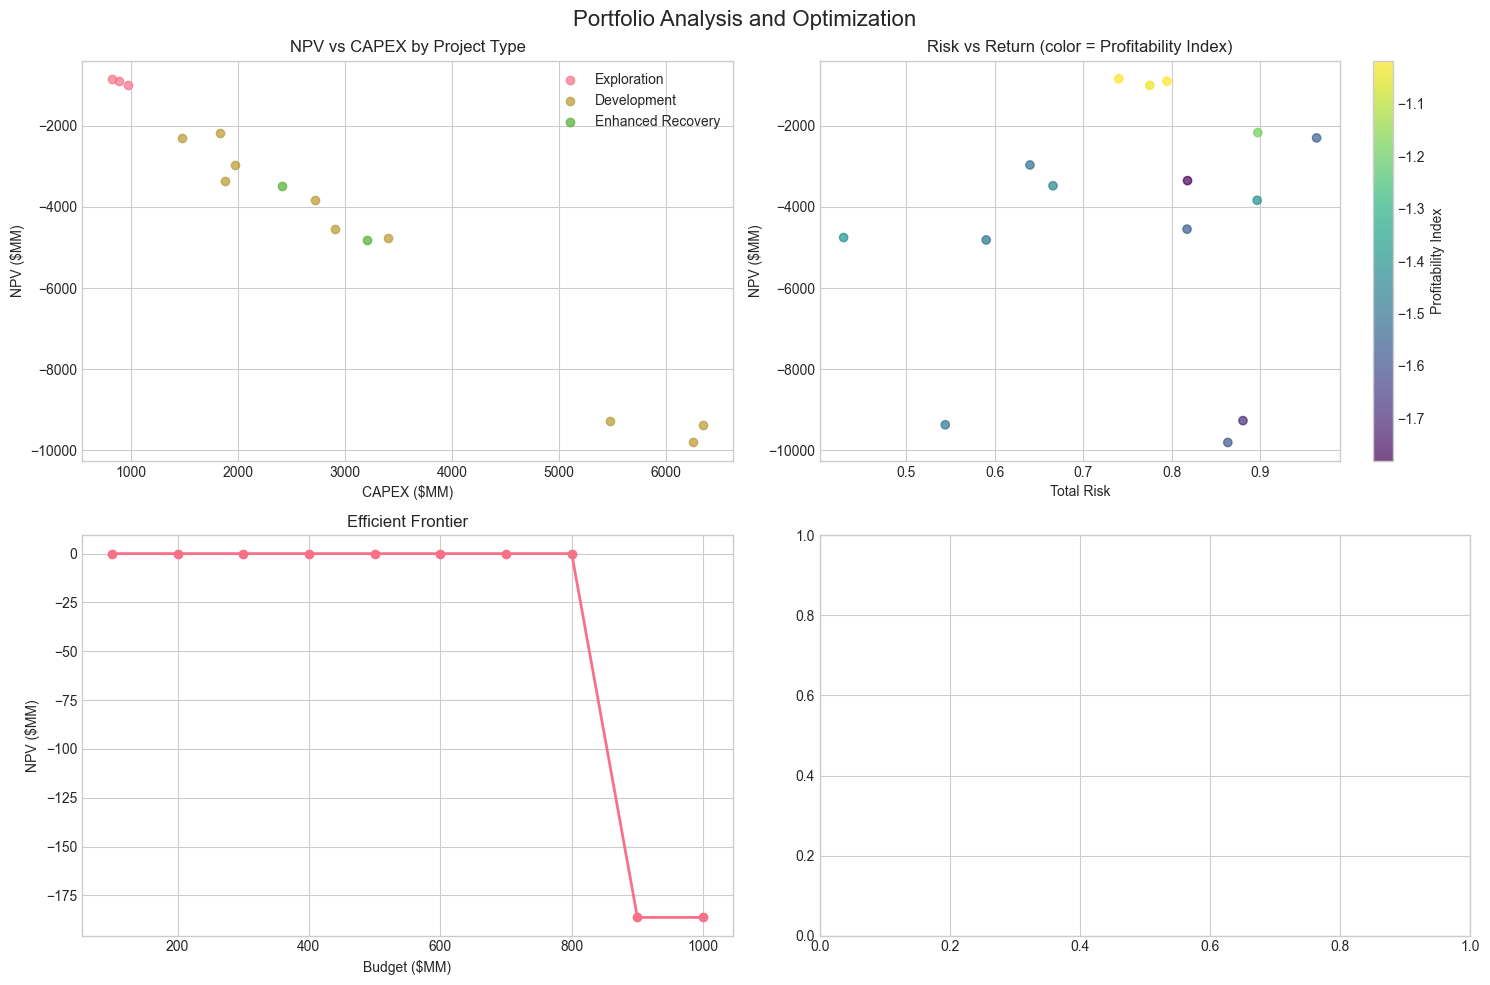

Portfolio analysis completed and results saved.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create synthetic project portfolio
def create_project_portfolio(n_projects=15):
    """Create a portfolio of oil and gas projects with realistic parameters"""
    
    projects = []
    
    for i in range(n_projects):
        # Project type
        project_type = np.random.choice(
            ['Exploration', 'Development', 'Enhanced Recovery'], 
            p=[0.3, 0.5, 0.2]
        )
        
        # Project parameters based on type
        if project_type == 'Exploration':
            success_prob = np.random.uniform(0.1, 0.4)
            capex = np.random.lognormal(7, 0.5)
            opex = capex * np.random.uniform(0.05, 0.1)
            reserves = np.random.lognormal(2.5, 0.8) if np.random.random() < success_prob else 0
            duration = np.random.uniform(2, 5)
            
        elif project_type == 'Development':
            success_prob = 0.8
            capex = np.random.lognormal(8, 0.4)
            opex = capex * np.random.uniform(0.1, 0.2)
            reserves = np.random.lognormal(3, 0.6)
            duration = np.random.uniform(5, 15)
            
        else:  # Enhanced Recovery
            success_prob = 0.7
            capex = np.random.lognormal(7.5, 0.3)
            opex = capex * np.random.uniform(0.15, 0.25)
            reserves = np.random.lognormal(2, 0.5)
            duration = np.random.uniform(3, 8)
        
        # Risk factors
        technical_risk = np.random.uniform(0.1, 0.5)
        market_risk = np.random.uniform(0.1, 0.4)
        regulatory_risk = np.random.uniform(0.05, 0.3)
        
        # Economic parameters
        oil_price = np.random.uniform(50, 90)
        discount_rate = np.random.uniform(0.08, 0.15)
        
        project = {
            'Project_ID': f'P{i:03d}',
            'Project_Type': project_type,
            'Success_Probability': success_prob,
            'CAPEX_MM': capex,
            'OPEX_MM': opex,
            'Reserves_MMbbl': reserves,
            'Duration_years': duration,
            'Technical_Risk': technical_risk,
            'Market_Risk': market_risk,
            'Regulatory_Risk': regulatory_risk,
            'Oil_Price_Assumption': oil_price,
            'Discount_Rate': discount_rate
        }
        
        projects.append(project)
    
    return pd.DataFrame(projects)

# Create project portfolio
print("Creating project portfolio...")
project_portfolio = create_project_portfolio(n_projects=15)

# Economic evaluation functions
def calculate_npv(capex, opex, reserves, oil_price, discount_rate, duration, success_prob=1.0):
    """Calculate NPV of a project"""
    
    # Annual production (simplified)
    annual_production = reserves / duration if duration > 0 else 0
    
    # Annual cash flows
    years = np.arange(1, duration + 1)
    revenue = annual_production * oil_price
    cash_flow = (revenue - opex) * success_prob
    
    # Discount factors
    discount_factors = 1 / (1 + discount_rate) ** years
    
    # NPV
    npv = -capex + np.sum(cash_flow * discount_factors)
    
    return npv

def calculate_emv(npv, success_prob):
    """Calculate Expected Monetary Value"""
    return npv * success_prob

# Calculate economic metrics for each project
print("Calculating economic metrics...")
economic_metrics = []
for _, project in project_portfolio.iterrows():
    npv = calculate_npv(
        project['CAPEX_MM'], project['OPEX_MM'], project['Reserves_MMbbl'],
        project['Oil_Price_Assumption'], project['Discount_Rate'], project['Duration_years'],
        project['Success_Probability']
    )
    
    emv = calculate_emv(npv, project['Success_Probability'])
    
    # Risk-adjusted metrics
    risk_factor = project['Technical_Risk'] + project['Market_Risk'] + project['Regulatory_Risk']
    risk_adjusted_npv = npv * (1 - risk_factor)
    
    economic_metrics.append({
        'Project_ID': project['Project_ID'],
        'NPV_MM': npv,
        'EMV_MM': emv,
        'Risk_Adjusted_NPV_MM': risk_adjusted_npv,
        'PI': npv / project['CAPEX_MM'] if project['CAPEX_MM'] > 0 else 0
    })

economic_df = pd.DataFrame(economic_metrics)
project_portfolio = project_portfolio.merge(economic_df, on='Project_ID')

# Portfolio optimization
def optimize_portfolio(projects, budget_constraint, risk_tolerance=0.3):
    """Optimize project portfolio selection"""
    
    # Prepare data for optimization
    n_projects = len(projects)
    npvs = projects['Risk_Adjusted_NPV_MM'].values
    capex = projects['CAPEX_MM'].values
    risks = (projects['Technical_Risk'] + projects['Market_Risk'] + projects['Regulatory_Risk']).values
    
    # Objective function: maximize NPV
    def objective(x):
        return -np.sum(x * npvs)  # Negative for minimization
    
    # Constraints
    # Budget constraint
    from scipy.optimize import LinearConstraint
    budget_constraint = LinearConstraint(capex, lb=0, ub=budget_constraint)
    
    # Risk constraint
    from scipy.optimize import NonlinearConstraint
    def risk_constraint(x):
        total_risk = np.sum(x * risks)
        total_selected = np.sum(x)
        return risk_tolerance - total_risk / total_selected if total_selected > 0 else 0
    
    nonlinear_constraint = NonlinearConstraint(risk_constraint, lb=0, ub=np.inf)
    
    # Bounds
    bounds = [(0.0, 1.0)] * n_projects
    
    # Initial guess
    x0 = np.ones(n_projects) * 0.5
    
    # Run optimization
    result = minimize(
        objective, x0, 
        constraints=[budget_constraint, nonlinear_constraint],
        bounds=bounds,
        method='SLSQP',
        options={'maxiter': 100, 'disp': False}
    )
    
    return result

# Run portfolio optimization
budget = 500  # $500 million budget
print(f"Running portfolio optimization with ${budget}MM budget...")
result = optimize_portfolio(project_portfolio, budget)

# Process optimization results
selected_projects = result.x > 0.5
optimized_portfolio = project_portfolio[selected_projects].copy()

print(f"Selected {np.sum(selected_projects)} projects")
print(f"Total CAPEX: ${optimized_portfolio['CAPEX_MM'].sum():.2f}MM")
print(f"Total Risk-Adjusted NPV: ${optimized_portfolio['Risk_Adjusted_NPV_MM'].sum():.2f}MM")

# Create efficient frontier
def calculate_efficient_frontier(projects, budget_range):
    """Calculate efficient frontier for portfolio optimization"""
    
    frontier = []
    
    for budget in budget_range:
        # Simple greedy algorithm for efficient frontier
        projects_sorted = projects.sort_values('PI', ascending=False)
        cumulative_capex = 0
        selected_npv = 0
        selected_risk = 0
        
        for _, project in projects_sorted.iterrows():
            if cumulative_capex + project['CAPEX_MM'] <= budget:
                cumulative_capex += project['CAPEX_MM']
                selected_npv += project['Risk_Adjusted_NPV_MM']
                selected_risk += (project['Technical_Risk'] + project['Market_Risk'] + project['Regulatory_Risk'])
        
        frontier.append({
            'Budget_MM': budget,
            'NPV_MM': selected_npv,
            'Risk': selected_risk,
            'Number_of_Projects': int(np.sum(projects_sorted['CAPEX_MM'].cumsum() <= budget))
        })
    
    return pd.DataFrame(frontier)

# Calculate efficient frontier
budget_range = np.linspace(100, 1000, 10)
efficient_frontier = calculate_efficient_frontier(project_portfolio, budget_range)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Analysis and Optimization', fontsize=16)

# Plot 1: NPV vs CAPEX by project type
for project_type in project_portfolio['Project_Type'].unique():
    data = project_portfolio[project_portfolio['Project_Type'] == project_type]
    axes[0, 0].scatter(data['CAPEX_MM'], data['NPV_MM'], label=project_type, alpha=0.7)

axes[0, 0].set_xlabel('CAPEX ($MM)')
axes[0, 0].set_ylabel('NPV ($MM)')
axes[0, 0].set_title('NPV vs CAPEX by Project Type')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Risk vs Return
axes[0, 1].scatter(
    project_portfolio['Technical_Risk'] + project_portfolio['Market_Risk'] + project_portfolio['Regulatory_Risk'],
    project_portfolio['NPV_MM'],
    c=project_portfolio['PI'], cmap='viridis', alpha=0.7
)
axes[0, 1].set_xlabel('Total Risk')
axes[0, 1].set_ylabel('NPV ($MM)')
axes[0, 1].set_title('Risk vs Return (color = Profitability Index)')
plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1], label='Profitability Index')
axes[0, 1].grid(True)

# Plot 3: Efficient Frontier
axes[1, 0].plot(efficient_frontier['Budget_MM'], efficient_frontier['NPV_MM'], 'o-', linewidth=2)
axes[1, 0].set_xlabel('Budget ($MM)')
axes[1, 0].set_ylabel('NPV ($MM)')
axes[1, 0].set_title('Efficient Frontier')
axes[1, 0].grid(True)

# Plot 4: Optimized Portfolio Composition
if not optimized_portfolio.empty:
    portfolio_composition = optimized_portfolio['Project_Type'].value_counts()
    axes[1, 1].pie(portfolio_composition.values, labels=portfolio_composition.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Optimized Portfolio Composition')

plt.tight_layout()
plt.savefig('portfolio_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Save all results
project_portfolio.to_csv('project_portfolio.csv', index=False)
optimized_portfolio.to_csv('optimized_portfolio.csv', index=False)
efficient_frontier.to_csv('efficient_frontier.csv', index=False)

# Create summary report
summary_report = {
    'Total_Projects': len(project_portfolio),
    'Selected_Projects': len(optimized_portfolio),
    'Total_Budget_MM': optimized_portfolio['CAPEX_MM'].sum(),
    'Total_NPV_MM': optimized_portfolio['NPV_MM'].sum(),
    'Total_Risk_Adjusted_NPV_MM': optimized_portfolio['Risk_Adjusted_NPV_MM'].sum(),
    'Average_PI': optimized_portfolio['PI'].mean()
}

summary_df = pd.DataFrame([summary_report])
summary_df.to_csv('portfolio_summary.csv', index=False)

print("Portfolio analysis completed and results saved.")

5 CSV Data Visualization

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime

# Set the style
plt.style.use('default')
sns.set_palette("husl")

# Create output directory for visualizations
os.makedirs('project_visualizations', exist_ok=True)

# Function to create visualizations from CSV files
def visualize_csv_data():
    # 1. Visualize well analysis data (Project #2)
    try:
        well_data = pd.read_csv('advanced_well_analysis.csv')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Well Log Analysis Results', fontsize=16)
        
        # Porosity vs Permeability
        axes[0, 0].scatter(well_data['PHIA'], well_data['PERM_TIMUR'], alpha=0.6)
        axes[0, 0].set_xlabel('Porosity')
        axes[0, 0].set_ylabel('Permeability (mD)')
        axes[0, 0].set_title('Porosity vs Permeability')
        axes[0, 0].set_yscale('log')
        
        # Water Saturation Distribution
        axes[0, 1].hist(well_data['SW_ARCHIE'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 1].set_xlabel('Water Saturation')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Water Saturation Distribution')
        
        # Lithology Distribution
        lith_counts = well_data['LITHOLOGY'].value_counts()
        axes[1, 0].bar(lith_counts.index, lith_counts.values, alpha=0.7)
        axes[1, 0].set_xlabel('Lithology')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Lithology Distribution')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # VShale Distribution
        axes[1, 1].hist(well_data['VSHALE_GR'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel('VShale')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('VShale Distribution')
        
        plt.tight_layout()
        plt.savefig('project_visualizations/well_analysis_visualization.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Well analysis visualization created successfully")
    except Exception as e:
        print(f"Error creating well analysis visualization: {e}")
    
    # 2. Visualize production data (Project #3)
    try:
        production_data = pd.read_csv('advanced_production_data.csv')
        production_data['DATE'] = pd.to_datetime(production_data['DATE'])
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Production Data Analysis', fontsize=16)
        
        # Oil production trend
        for well in production_data['WELL'].unique()[:5]:  # Show first 5 wells
            well_data = production_data[production_data['WELL'] == well]
            axes[0, 0].plot(well_data['DATE'], well_data['OIL_RATE'], label=well, alpha=0.7)
        
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Oil Rate (bbl/day)')
        axes[0, 0].set_title('Oil Production Trends')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Water cut distribution
        water_cut_data = production_data.groupby('WELL')['WATER_CUT'].mean()
        axes[0, 1].bar(water_cut_data.index, water_cut_data.values, alpha=0.7)
        axes[0, 1].set_xlabel('Well')
        axes[0, 1].set_ylabel('Average Water Cut')
        axes[0, 1].set_title('Water Cut by Well')
        axes[0, 1].tick_params(axis='x', rotation=90)
        
        # Production type comparison
        prod_types = ['OIL_RATE', 'WATER_RATE', 'LIQUID_RATE']
        avg_production = production_data[prod_types].mean()
        axes[1, 0].bar(avg_production.index, avg_production.values, alpha=0.7)
        axes[1, 0].set_xlabel('Production Type')
        axes[1, 0].set_ylabel('Average Rate (bbl/day)')
        axes[1, 0].set_title('Average Production by Type')
        
        # Well type performance
        well_type_perf = production_data.groupby('WELL_TYPE')['OIL_RATE'].mean()
        axes[1, 1].bar(well_type_perf.index, well_type_perf.values, alpha=0.7)
        axes[1, 1].set_xlabel('Well Type')
        axes[1, 1].set_ylabel('Average Oil Rate (bbl/day)')
        axes[1, 1].set_title('Performance by Well Type')
        
        plt.tight_layout()
        plt.savefig('project_visualizations/production_data_visualization.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Production data visualization created successfully")
    except Exception as e:
        print(f"Error creating production visualization: {e}")
    
    # 3. Visualize portfolio data (Project #4)
    try:
        portfolio_data = pd.read_csv('project_portfolio.csv')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Portfolio Analysis', fontsize=16)
        
        # NPV by project type
        type_npv = portfolio_data.groupby('Project_Type')['NPV_MM'].mean()
        axes[0, 0].bar(type_npv.index, type_npv.values, alpha=0.7)
        axes[0, 0].set_xlabel('Project Type')
        axes[0, 0].set_ylabel('Average NPV ($MM)')
        axes[0, 0].set_title('NPV by Project Type')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Risk vs Return
        axes[0, 1].scatter(
            portfolio_data['Technical_Risk'] + portfolio_data['Market_Risk'] + portfolio_data['Regulatory_Risk'],
            portfolio_data['NPV_MM'],
            alpha=0.7
        )
        axes[0, 1].set_xlabel('Total Risk Score')
        axes[0, 1].set_ylabel('NPV ($MM)')
        axes[0, 1].set_title('Risk vs Return')
        
        # CAPEX distribution
        axes[1, 0].hist(portfolio_data['CAPEX_MM'], bins=10, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('CAPEX ($MM)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('CAPEX Distribution')
        
        # Success probability by type
        success_prob = portfolio_data.groupby('Project_Type')['Success_Probability'].mean()
        axes[1, 1].bar(success_prob.index, success_prob.values, alpha=0.7)
        axes[1, 1].set_xlabel('Project Type')
        axes[1, 1].set_ylabel('Success Probability')
        axes[1, 1].set_title('Success Probability by Project Type')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('project_visualizations/portfolio_analysis_visualization.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Portfolio analysis visualization created successfully")
    except Exception as e:
        print(f"Error creating portfolio visualization: {e}")
    
    # 4. Create a summary dashboard
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Project Summary Dashboard', fontsize=16)
        
        # Load all data
        well_data = pd.read_csv('advanced_well_analysis.csv')
        production_data = pd.read_csv('advanced_production_data.csv')
        portfolio_data = pd.read_csv('project_portfolio.csv')
        
        # Top left: Average porosity by lithology
        porosity_by_lith = well_data.groupby('LITHOLOGY')['PHIA'].mean()
        axes[0, 0].bar(porosity_by_lith.index, porosity_by_lith.values, alpha=0.7)
        axes[0, 0].set_xlabel('Lithology')
        axes[0, 0].set_ylabel('Average Porosity')
        axes[0, 0].set_title('Porosity by Lithology')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Top right: Production distribution by well type
        production_data['WELL_TYPE'] = production_data['WELL_TYPE'].fillna('Unknown')
        prod_by_type = production_data.groupby('WELL_TYPE')['OIL_RATE'].mean()
        axes[0, 1].bar(prod_by_type.index, prod_by_type.values, alpha=0.7)
        axes[0, 1].set_xlabel('Well Type')
        axes[0, 1].set_ylabel('Average Oil Production (bbl/day)')
        axes[0, 1].set_title('Production by Well Type')
        
        # Bottom left: NPV distribution by project type
        npv_by_type = portfolio_data.groupby('Project_Type')['NPV_MM'].mean()
        axes[1, 0].bar(npv_by_type.index, npv_by_type.values, alpha=0.7)
        axes[1, 0].set_xlabel('Project Type')
        axes[1, 0].set_ylabel('Average NPV ($MM)')
        axes[1, 0].set_title('NPV by Project Type')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Bottom right: Risk comparison
        risk_data = portfolio_data[['Technical_Risk', 'Market_Risk', 'Regulatory_Risk']].mean()
        axes[1, 1].bar(risk_data.index, risk_data.values, alpha=0.7)
        axes[1, 1].set_xlabel('Risk Type')
        axes[1, 1].set_ylabel('Average Risk Score')
        axes[1, 1].set_title('Risk Profile')
        
        plt.tight_layout()
        plt.savefig('project_visualizations/summary_dashboard.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Summary dashboard created successfully")
    except Exception as e:
        print(f"Error creating summary dashboard: {e}")

# Run the visualization function
visualize_csv_data()

Well analysis visualization created successfully
Production data visualization created successfully
Portfolio analysis visualization created successfully
Summary dashboard created successfully
